In [45]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [46]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [47]:
input_dim = (28, 28, 1)
z_dim = 2

### Encoder

In [48]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_2')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_3')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

De encoder komt overeen met de `encoder` van de autoencoder. Het verschil zit in de volgende stap, waarin twee parallele Dense lagen het gemiddelde en de log van de variantie teruggeven.

In [49]:
mu = Dense(z_dim, name = 'mu')(x)
log_var = Dense(z_dim, name = 'log_var')(x)

In [50]:
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape = K.shape(mu), mean = 0, stddev =  1.)
    return mu + K.exp(log_var / 2) * epsilon

Een `Lambda` laag is een manier om een willekeurige bewerking in een Keras laag uit te voeren.
Onderstaande laag kiest een willekeurig getal volgens de verdeling bepaald door `mu` en `log_var`.

In [51]:
encoder_output = Lambda(sampling, name = 'encoder_output')([mu, log_var])

encoder = Model(encoder_input, encoder_output)

In [52]:
encoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 28, 28, 32)   0           ['encoder_conv_1[0][0]']         
                                                                                                  
 encoder_conv_2 (Conv2D)        (None, 14, 14, 64)   18496       ['leaky_re_lu_24[0][0]']         
                                                                                            

Bekijk de `summary` van de encoder. Komt deze overeen met je verwachtingen?

### Decoder

De `decoder` komt overeen met de `decoder` van de Autoencoder.

In [53]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 32,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

In [54]:
decoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 1568)              4704      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 7, 7, 64)         18496     
 nspose)                                                         
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_2 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                  

### De volledige variational autoencoder

In [55]:
vae = Model(encoder_input, decoder(encoder_output))

In [56]:
r_loss_factor = 1500

def r_loss(y_true, y_pred):
    return r_loss_factor * K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def vae_kl_loss(y_true, y_pred):
    return -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)

def vae_loss(y_true, y_pred):
    return r_loss(y_true, y_pred) + vae_kl_loss(y_true, y_pred)


Compileer en train de variational autoencoder.

In [57]:
learning_rate = 0.0005

optimizer = Adam(learning_rate = learning_rate)

vae.compile(optimizer = optimizer, loss = vae_loss,  metrics = [r_loss, vae_kl_loss])

In [62]:
subset = 20000

vae.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 7, shuffle = True)

Train on 20000 samples
Epoch 1/7
20000/20000 [==============================] - 23s 1ms/sample - loss: 74.5725 - r_loss: 70.0373 - vae_kl_loss: 4.5352
Epoch 2/7
20000/20000 [==============================] - 25s 1ms/sample - loss: 74.0283 - r_loss: 69.3780 - vae_kl_loss: 4.6503
Epoch 3/7
20000/20000 [==============================] - 23s 1ms/sample - loss: 73.4841 - r_loss: 68.7620 - vae_kl_loss: 4.7222
Epoch 4/7
20000/20000 [==============================] - 22s 1ms/sample - loss: 72.9374 - r_loss: 68.1778 - vae_kl_loss: 4.7596
Epoch 5/7
20000/20000 [==============================] - 23s 1ms/sample - loss: 72.5080 - r_loss: 67.6926 - vae_kl_loss: 4.8154
Epoch 6/7
20000/20000 [==============================] - 23s 1ms/sample - loss: 72.1242 - r_loss: 67.2622 - vae_kl_loss: 4.8619
Epoch 7/7
20000/20000 [==============================] - 24s 1ms/sample - loss: 71.7760 - r_loss: 66.8374 - vae_kl_loss: 4.9386


### Reconstructie van originele afbeeldingen

We selecteren willekeurige afbeeldingen, coderen deze met de `encoder` en decoderen deze met de `decoder`.

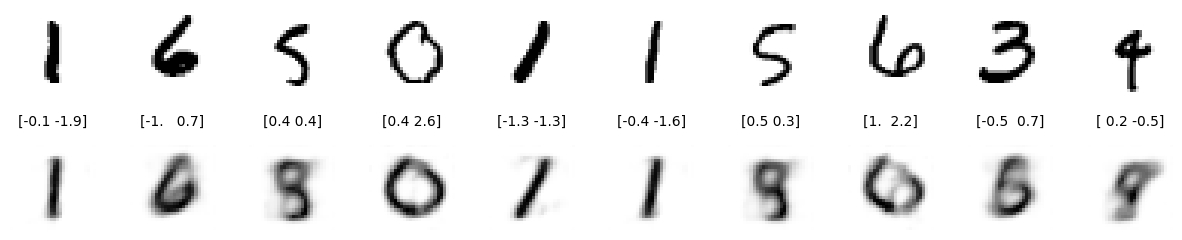

In [66]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Wat valt je op aan de reconstructies?

<b>

De reconstructies zijn aanzienlijk nauwkeuriger in vergelijking met de normale auto-encoder. Bijna alle reconstructies zijn correct, behalve twee. Ik merk op dat de decoder de cijfers 3 en 5 door elkaar haalt.

Om een beter beeld te krijgen van het gedrag van de autoencoder, plotten we de outputs van de encoder (de 'z-waarden') voor een deel van de testset. De kleur van een punt geeft het correcte label weer.

Daarnaast selecteren we alvast een aantal willekeurige punten (dus een combinatie van twee willekeurige getallen) die we dadelijk gaan gebruiken om volledig nieuwe afbeeldingen te genereren. Deze punten worden in het rood weergegeven.

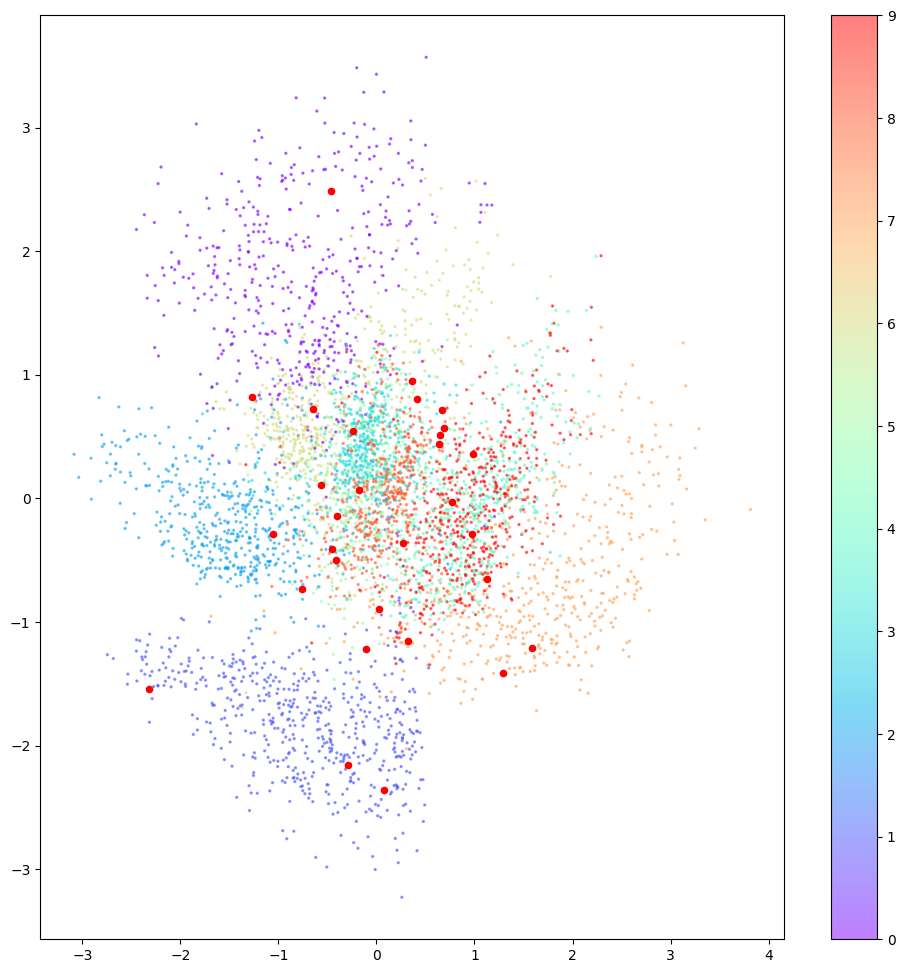

In [64]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

Wat valt je op aan deze plot, vergeleken met dezelfde plot bij de Autoencoder?

<b>
Deze plot vertoont een betere spreiding dan die van de auto-encoder. Ik merk ook op dat de spreiding van de cijfers 8 en 9 zich op de verkeerde plaats bevindt.

We gebruiken nu de decoder om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

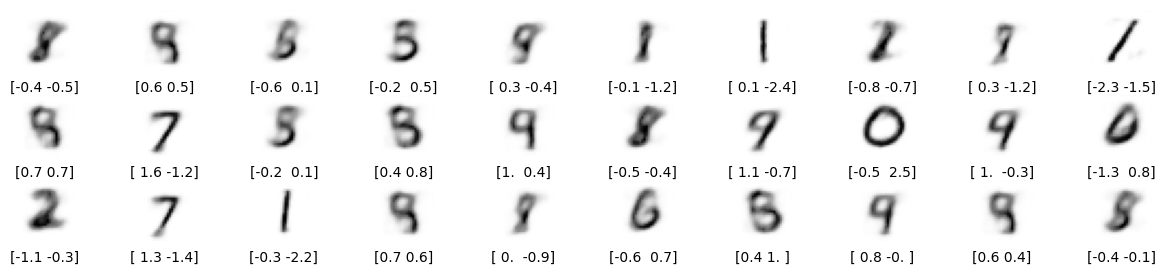

In [68]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')